In [66]:
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_community.utilities import SerpAPIWrapper
from langgraph.types import interrupt
from IPython.display import Image, display

In [67]:
# ---------- state ----------
class State(TypedDict):
    messages: List[str]          # plain strings for readability

In [68]:
# ---------- LLM ----------
llm = ChatOllama(model="llama3.2", temperature=0)

In [69]:
# ---------- tools ----------
search = SerpAPIWrapper(serpapi_api_key="fd59e5bf32211fb3000174930d1c0bca346b079d47e96e0c0b69acb7e5af1d9b")

In [70]:
def chat_node(state: State):
    # Call LLM and append its answer
    # build one prompt from history
    prompt = "\n".join(state["messages"]) + "\nAssistant:"
    ai_reply = llm.invoke(prompt).content
    return {"messages": state["messages"] + [ai_reply]}

In [91]:
keywords = [
    "don't have real-time information",
    "don't have real-time access",
    "don't have any information",
    "knowledge cutoff is december 2023",
    "my knowledge cutoff",
    "I do not have real-time"
    ]

In [92]:
def router(state: State) -> Literal["approve_search", "answer"]:
    # Look at the *AI reply* (last message) and decide.
    last = state["messages"][-1].lower()
    for i in keywords:
        if i.lower() in last:
            return "approve_search"
    return "answer"

In [73]:
def approve_search(state: State):
    # Ask user before burning API credits.
    print("# --------------- Inside approve search node ---------------- #")
    cmd = input("The bot wants to call paid web search. Allow? (y/n)")
    if cmd.strip() != "y":
        return {"messages": state["messages"] + ["[User declined search]"]}
    # user said yes → run tool
    print("# ---------------- Giving response from API Calling ------------------- #")
    question = state["messages"][-2]   # user question is 2nd last
    result = search.run(question)
    return {"messages": state["messages"] + [result]}

In [74]:
def summarise(state: State):
    # Will give short answer to response generated from search API
    API_response = state["messages"][-1]
    User_Question = state["messages"][-2]
    prompt = "\n".join(f"""
                       I have provided this question - {User_Question} | 
                       and API response is {API_response} |
                       I want you to understand API response and give me summarised answer to my question.
                       Go ahead.
                       """)
    summarised_output = llm.invoke(prompt).content
    return {"messages": state["messages"] + [summarised_output]}

In [75]:
def answer(state: State):
    """Normal reply path when no search is needed."""
    # already answered in chat_node, just END
    print("# ------------------ Just LLM Response ------------------- #")
    return {}

In [93]:
# ---------- graph ----------
builder = StateGraph(State)
builder.add_node("chat", chat_node)
builder.add_node("approve_search", approve_search)
builder.add_node("answer", answer)
builder.add_node("summarise",summarise)

builder.add_edge(START, "chat")
builder.add_conditional_edges("chat", router, {
    "approve_search": "approve_search",
    "answer": "answer"
})
builder.add_edge("approve_search", "summarise")
builder.add_edge("summarise",END)
builder.add_edge("answer", END)

In [94]:
graph = builder.compile()

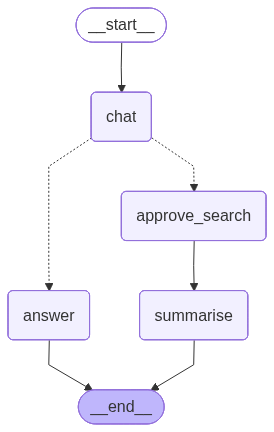

In [95]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [96]:
while True:
        q = input("\nYou: ")
        if q.lower() in {"exit", "quit","q"}:
            break
        # user question is appended *before* the graph runs
        state_in = {"messages": [f"User: {q}"]}
        final_state = graph.invoke(state_in)
        print("Bot:", final_state["messages"][-1])

# --------------- Inside approve search node ---------------- #
# ---------------- Giving response from API Calling ------------------- #
Bot: It appears that you have provided a large amount of text data, but it seems to be a jumbled collection of words and phrases without any clear structure or organization. The text includes various topics such as:

1. A list of dates (2025, 2017, 2022, etc.)
2. Names (ICC, IC, Kaur, etc.)
3. Places (India, China, etc.)
4. Events (elections, protests, etc.)
5. Organizations (APIS, etc.)

However, without more context or information about what this text is supposed to be, it's difficult to provide a meaningful analysis or interpretation.

If you could provide more context or clarify the purpose of this text, I'd be happy to try and assist you further.
